In [6]:
import urllib
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import os 
from PIL import Image
import random
import xml.etree.ElementTree as ET
import time
import requests

- dataset: https://www.kaggle.com/andrewmvd/leaf-type-detection

In [2]:
dir_path = 'images'
xml_path = 'annotations'
file_list = os.listdir(dir_path)
print(f'There are total {len(file_list)} images.')

There are total 2330 images.


## [optional] the class labels for the dataset
- optional
    - show all the classes in the dataset

In [38]:
classes = set()
for i in range(2330):
    file_label = 'annotations/plantdoc'+ str(i) + '.xml'
    with open(file_label) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')
        for idx in objects:
            classes.add(find_label(idx))

In [39]:
classes

{'Apple Scab Leaf',
 'Apple leaf',
 'Apple rust leaf',
 'Bell_pepper leaf',
 'Bell_pepper leaf spot',
 'Blueberry leaf',
 'Cherry leaf',
 'Corn Gray leaf spot',
 'Corn leaf blight',
 'Corn rust leaf',
 'Peach leaf',
 'Potato leaf',
 'Potato leaf early blight',
 'Potato leaf late blight',
 'Raspberry leaf',
 'Soyabean leaf',
 'Soybean leaf',
 'Squash Powdery mildew leaf',
 'Strawberry leaf',
 'Tomato Early blight leaf',
 'Tomato Septoria leaf spot',
 'Tomato leaf',
 'Tomato leaf bacterial spot',
 'Tomato leaf late blight',
 'Tomato leaf mosaic virus',
 'Tomato leaf yellow virus',
 'Tomato mold leaf',
 'Tomato two spotted spider mites leaf',
 'grape leaf',
 'grape leaf black rot'}

## [optional] Remove images in the dataset that doesn't have category overlap with plantVillage
- optional
    - if we remove images, than the order would have problems

In [11]:
label_mapping = {
        'Bell_pepper leaf spot': 0,
        'Bell_pepper leaf': 1,
#         'Potato leaf early blight': 2,
#         'Potato leaf late blight': 3,
#         'Potato leaf': 4,
        'Tomato leaf bacterial spot': 5,
#         'Tomato Early blight leaf': 6,
        'Tomato leaf late blight': 7,
        'Tomato mold leaf': 8,
        'Tomato Septoria leaf spot': 9,
        'Tomato two spotted spider mites leaf': 10,
        'Tomato leaf yellow virus': 12,
#         'Tomato leaf mosaic virus': 13,
        'Tomato leaf': 14
}
for i in range(2330):
    file_label = 'annotations/plantdoc'+ str(i) + '.xml'
    file_image = 'images/plantdoc'+ str(i) + '.png'
    with open(file_label) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')
        removed_flag = False
        for idx in objects:
            if idx.find('name').text not in label_mapping.keys():
                removed_flag = True
        if removed_flag == True:
            os.remove(file_label)
            os.remove(file_image)

## Prepare dataset

In [34]:
def generate_box(obj):
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    label_mapping = {
        'Bell_pepper leaf spot': 0,
        'Bell_pepper leaf': 1,
#         'Potato leaf early blight': 2,
#         'Potato leaf late blight': 3,
#         'Potato leaf': 4,
        'Tomato leaf bacterial spot': 5,
#         'Tomato Early blight leaf': 6,
        'Tomato leaf late blight': 7,
        'Tomato mold leaf': 8,
        'Tomato Septoria leaf spot': 9,
        'Tomato two spotted spider mites leaf': 10,
        'Tomato leaf yellow virus': 12,
#         'Tomato leaf mosaic virus': 13,
        'Tomato leaf': 14
    }
    if obj.find('name').text in label_mapping.keys():
        return label_mapping[obj.find('name').text]
    else:
        return -1
    
def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target
    

In [64]:
# v_2
def read_annot(file_name, xml_dir):
    """
    Function used to get the bounding boxes and labels from the xml file
    Input:
        file_name: image file name
        xml_dir: directory of xml file
    Return:
        bbox : list of bounding boxes
        labels: list of labels
    """
    bbox = []
    labels = []
    
    annot_path = os.path.join(xml_dir, file_name[:-3]+'xml')
    tree = ET.parse(annot_path)
    root = tree.getroot()
    for boxes in root.iter('object'):
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
#         label = boxes.find('name').text
        bbox.append([xmin,ymin,xmax,ymax])
#         if label == 'with_mask':
#             label_idx = 2
#         else:
#             label_idx = 1
        label_idx = generate_label(boxes)
        labels.append(label_idx)
        
    return bbox, labels

# help function for drawing bounding boxes on image
def draw_boxes(img, boxes,labels, thickness=1):
    """
    Function to draw bounding boxes
    Input:
        img: array of img (h, w ,c)
        boxes: list of boxes (int)
        labels: list of labels (int)
    
    """
#     print(boxes)
#     print(labels)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for box,label in zip(boxes,labels):
        box = [int(x) for x in box]
        if label >= 0:
            color = (0,0,225) # red
        else:
            color = (0,225,0)
        cv2.rectangle(img, (box[0],box[1]),(box[2],box[3]),color,thickness)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


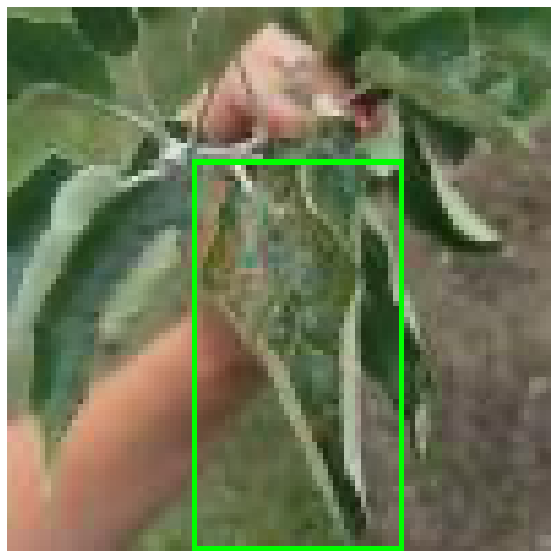

In [65]:
# Get the image randomly
# image_name = file_list[random.randint(0,len(file_list))] # random select an image
image_name = file_list[1004]

# Get the bbox and label
bbox, labels  = read_annot(image_name, xml_path)

#draw bounding boxes on the image
img = draw_boxes(plt.imread(os.path.join(dir_path,image_name)), bbox,labels)
    
# display the image
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.axis('off')
ax.imshow(img)

In [66]:
# imgs = list(sorted(os.listdir('images/')))
# labels = list(sorted(os.listdir('annotations/')))
# data_transform = transforms.Compose([
#         transforms.ToTensor(), 
#     ])

In [28]:
class PlantDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir("images/")))
#         self.labels = list(sorted(os.listdir("/kaggle/input/face-mask-detection/annotations/")))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'plantdoc'+ str(idx) + '.png'
        file_label = 'plantdoc'+ str(idx) + '.xml'
        img_path = os.path.join("images/", file_image)
        label_path = os.path.join("annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [29]:
dataset = PlantDataset(data_transform)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)

In [30]:
# Setting up GPU device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [31]:
# Setting up the model
num_classes=10
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.to(device)

In [32]:
# Setting the optimizer, lr_scheduler, epochs

params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.Adam(params, lr=0.01)
optimizer = torch.optim.SGD(params, lr=0.01,momentum=0.9, weight_decay=0.0005)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
num_epochs=30

In [33]:
# Main training function
loss_list = []

for epoch in range(num_epochs):
    print('Starting training....{}/{}'.format(epoch+1, num_epochs))
    loss_sub_list = []
    start = time.time()
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        
        model.train()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_sub_list.append(loss_value)
        
        # update optimizer and learning rate
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        #lr_scheduler.step()
    end = time.time()
        
    #print the loss of epoch
    epoch_loss = np.mean(loss_sub_list)
    loss_list.append(epoch_loss)
    print('Epoch loss: {:.3f} , time used: ({:.1f}s)'.format(epoch_loss, end-start))

Starting training....1/30


AttributeError: 'NoneType' object has no attribute 'text'